<a href="https://colab.research.google.com/github/Squirtle007/CUDA-Q/blob/main/colab/v0.9.1/03_compiling_unitaries_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install cudaq==0.9.1
!pip install genQC==0.1.0

Use this command to restart the kernel before importing packages:

In [ ]:
%reset -f

# Lab 3: Compiling Unitaries Using Diffusion Models

**What you'll do:**
* Synthesize quantum circuits corresponding to a given unitary matrix with diffusion model
* Evaluate if the circuit is obtained correctly
* Filter better quantum circuits

The notebook is organized as follows:
* Section 1: Overview of the Compiling Unitaries with Diffusion Models workflow
* Section 2: Generate circuits for a given unitary
* Section 3: Select a circuit that meets specific criteria

This notebook is based on the work presented in [Quantum circuit synthesis with diffusion models, Florian Fürrutter, Gorka Muñoz-Gil & Hans J. Briegel , Nat. Mach. Intell. **6**, 515–524 (2024)](https://doi.org/10.1038/s42256-024-00831-9).

Let's begin with installing the relevant packages.

In [ ]:
import functools
import itertools
import numpy as np
import torch
import cudaq

import genQC
from genQC.imports import *
from genQC.pipeline.diffusion_pipeline import DiffusionPipeline
from genQC.inference.export_cudaq import genqc_to_cudaq
import genQC.inference.infer_compilation as infer_comp
import genQC.util as util

# Fixed seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

## **Section 1** Overview

Quantum computing relies on efficiently translating quantum operations into viable physical realizations on existing quantum hardware. This compilation task can be an computationally intensive task. Recently machine learning techniques have demonstrated exceptional performance on this task (see for instance [(Moro et al., 2021)](https://www.nature.com/articles/s42005-021-00684-3) and [(Fürrutter, et al., 2024)](https://doi.org/10.1038/s42256-024-00831-9)).

This notebook focuses on circuit synthesis with diffusion models [(Fürrutter, et al., 2024)](https://doi.org/10.1038/s42256-024-00831-9) — a powerful class of generative models in machine learning. We will demonstrate how to use this method to synthesize arbitrary unitaries into a `cudaq.kernel`, effectively decomposing them into sequences of quantum gates, a process commonly known as unitary compilation.
In particular, we will use a pre-trained model to generate circuits with specific characteristics, such as being limited to a restricted set of gates, for a given unitary.  The following figure provides an overview of the circuit generation pipeline:


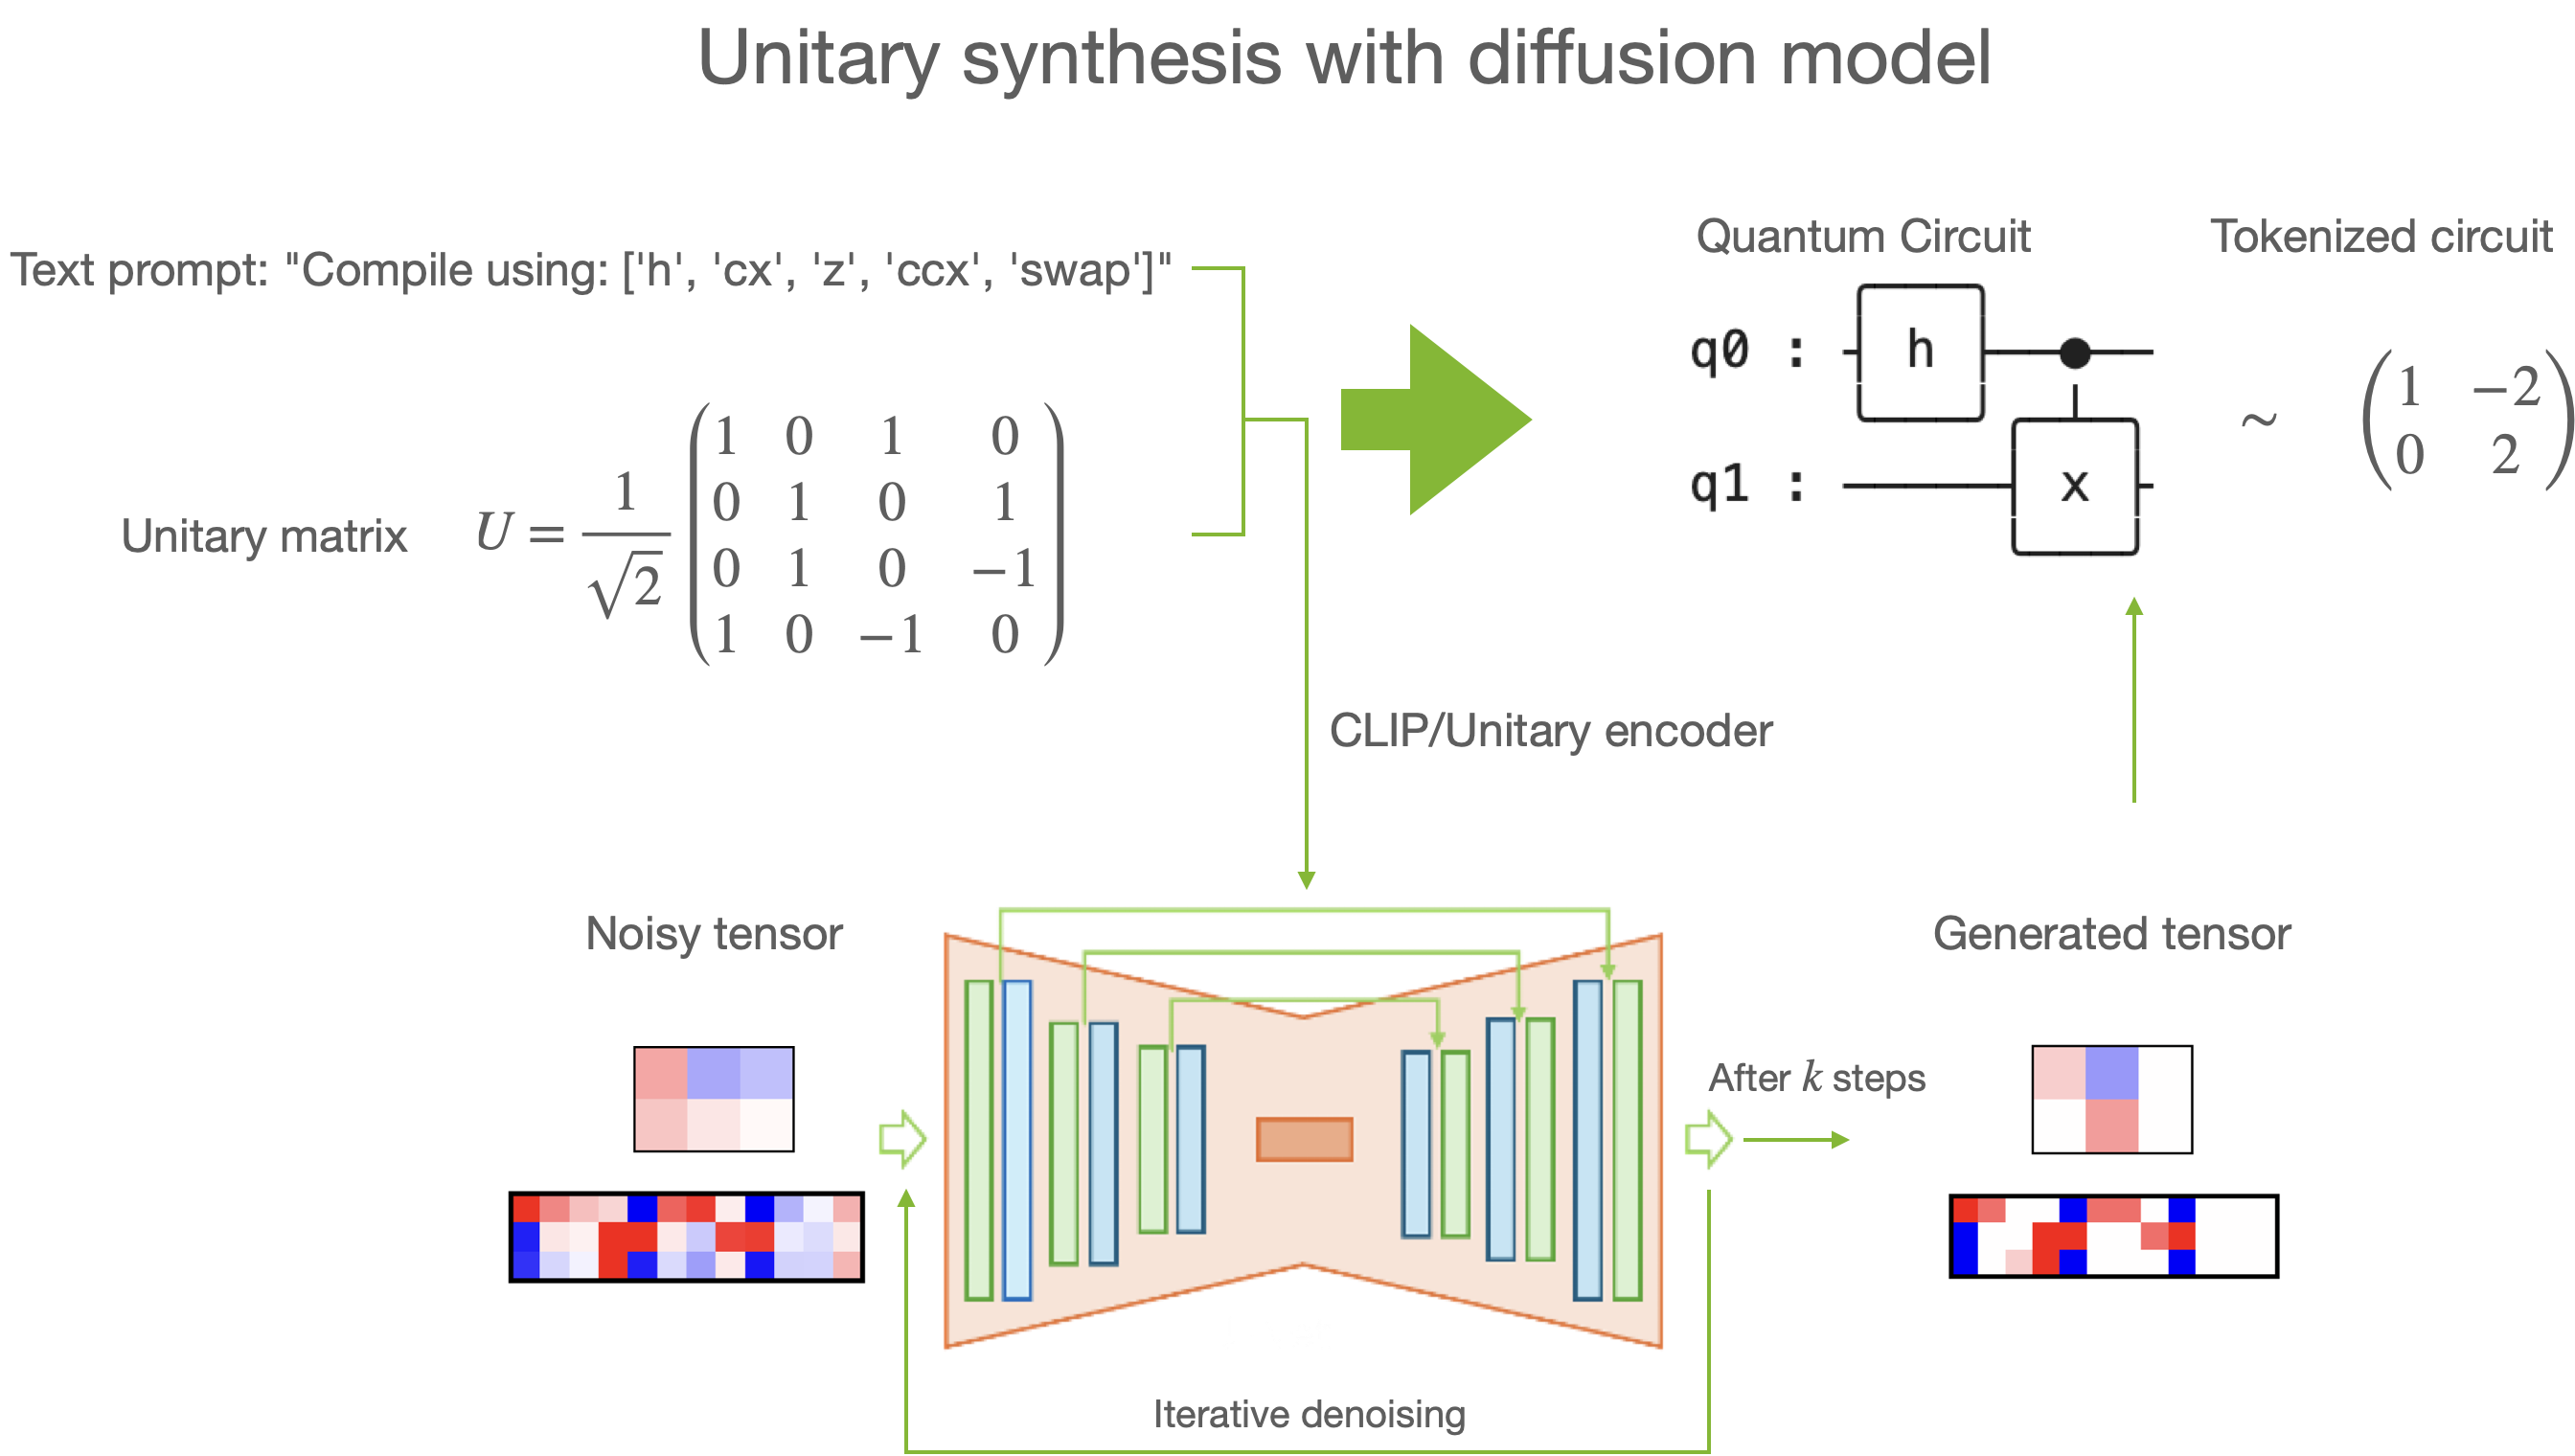

The pipeline consists on 3 main components:

**1) Circuit encoding:** Like any neural network, diffusion models operate with continuous inputs and outputs. However, since the circuits we consider are composed of discrete gates (i.e., with no continuous parameters), we develop a mapping that transforms each gate into a continuous vector. This allows us to represent a given circuit as a three-dimensional tensor, as illustrated. Crucially, this mapping is invertible: when the DM generates continuous tensors, we can apply the inverse map to convert them back into the circuit form.

**2) Conditioning:** The user's input (the set of available gates and the unitary to compile) is also transformed into a continuous tensor by two neural networks. For the gate set description, where the input is a text prompt (e.g., "Compile using ['x', 'h']"), we utilize a pre-trained language model. For the unitary, we employ a neural network that is training jointly with the diffusion model.

**3) Unitary compilation:** The generation procedure follows the typical DM process: the model is given a fully noisy tensor which is iteratively de-noised until reaching a clean sample based on the given conditioning (the desired unitary and gate set). The tensors generated by the DM are then mapped to circuits via the inverse encoding procedure. To learn more about the practical implementation of diffusion models we recommend [this tutorial](https://course.fast.ai/Lessons/lesson9.html).

In the following we will use `CUDA-Q` and `genQC` to perform all these steps and go from a desired unitary matrix, $U$, to a quantum circuit that we can execute using CUDA-Q.

## Generate circuits for a given unitary using a diffusion model

Let's start by defining the unitary we want to compile. Note that this model has been trained to compile unitaries that arise from circuits composed of the gates `['h', 'cx', 'z', 'x', 'ccx', 'swap']`. While this is a universal gate set (i.e. can perform universal computation), it can only do so with an infinite number of gates. For this tutorial we will use a model trained to generate kernels with at most 12 gates. Therefore, we can only expect the model to work for unitaries under this constraint. Let's consider here the compilation of one of such unitary.

We start by defining our unitary as a `numpy.array`:

In [ ]:
U = np.array(
    [
        [ 0.70710678,  0.        ,  0.        , 0.        ,  0.70710678,  0.        , 0.        ,  0.        ],
        [ 0.        , -0.70710678,  0.        , 0.        ,  0.        , -0.70710678, 0.        ,  0.        ],
        [-0.70710678,  0.        ,  0.        , 0.        ,  0.70710678,  0.        , 0.        ,  0.        ],
        [ 0.        ,  0.70710678,  0.        , 0.        ,  0.        , -0.70710678, 0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.70710678, 0.        ,  0.        ,  0.        , 0.        ,  0.70710678],
        [ 0.        ,  0.        ,  0.        , 0.70710678,  0.        ,  0.        , 0.70710678,  0.        ],
        [ 0.        ,  0.        , -0.70710678, 0.        ,  0.        ,  0.        , 0.        ,  0.70710678],
        [ 0.        ,  0.        ,  0.        ,-0.70710678,  0.        ,  0.        , 0.70710678,  0.        ]
    ],
    dtype=np.complex128
)

### The Diffusion Model

#### Setup and compilation

In [ ]:
device = util.infer_torch_device()  # Use CUDA if we can
util.MemoryCleaner.purge_mem()  # Clean existing memory allocation
print(device)

cpu


#### Load model

First, we load the pre-trained model weights and setup the DM pipeline.




In [ ]:
pipeline = DiffusionPipeline.from_pretrained("Floki00/qc_unitary_3qubit", device)  # Download from Hugging Face
pipeline.scheduler.set_timesteps(40)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model.pt:   0%|          | 0.00/28.8M [00:00<?, ?B/s]

config.yaml:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

[INFO]: `genQC.models.unet_qc.QC_Compilation_UNet` instantiated from given config on cpu.


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

[INFO]: `genQC.models.frozen_open_clip.CachedFrozenOpenCLIPEmbedder` instantiated from given config on cpu.
[INFO]: `genQC.models.frozen_open_clip.CachedFrozenOpenCLIPEmbedder`. No save_path` provided. No state dict loaded.


Next, we set parameters the model was trained on. Note that these are fixed and depend on the pre-trained model.

In [ ]:
vocab = {i + 1: gate for i, gate in enumerate(pipeline.gate_pool)}  # Gateset used during training, used for decoding
num_of_qubits = 3  # Number of qubits
max_gates = 12

### Unitary compilation

The loaded model was trained on the gate set `['h', 'cx', 'z', 'x', 'ccx', 'swap']`. Specifically, it was trained to generate circuits using any arbitrary subset of this gate set. Therefore, during inference, we can instruct the model to compile the unitary using any of these subsets. However, it is crucial to follow the prompt structure `Compile using [...]`, as the model was trained with this specific format. For example, let's consider a scenario where we compile the unitary without using the `x` gate:

In [ ]:
# Notice how the x gate is missing from the prompt since this is a restriction we set
prompt = "Compile using: ['h', 'cx', 'z', 'ccx', 'swap']"

Now, we call the diffusion model pipeline to generate encoded circuits based on the specified conditions: `prompt` and `U`. One of the key advantages of this method is that, once the model is trained, sampling new circuits is very fast. Therefore, under the same conditions defined above, we will generate 128 circuits and analyze them in the following sections.

In [ ]:
# Number of circuits to sample from the trained DM.
samples = 128

# As the neural network works only with real numbers, we first separate
# the two components and create a 2 dimensional tensor for the magnitude
# of each component:
U_r, U_i = torch.Tensor(np.real(U)), torch.Tensor(np.imag(U))
U_tensor = torch.stack([U_r, U_i], dim=0)

# Now we generate a tensor representation of the desired quantum circuit using the DM based on the prompt and U. This is also known as inference.
out_tensors = infer_comp.generate_comp_tensors(
    pipeline=pipeline,
    prompt=prompt,
    U=U_tensor,
    samples=samples,
    system_size=num_of_qubits,  # Max qubit number allowed by the model (this model is only trained with 3 qubits)
    num_of_qubits=num_of_qubits,
    max_gates=max_gates,
    g=10,  # classifier-free-guidance (CFG) scale
)

Below is an example of a generated tensor which represents a quantum circuit:

In [ ]:
out_tensors[0]

tensor([[ 5,  3,  0,  0,  0, -5,  0,  0,  0,  0,  0,  0],
        [-5,  0,  0,  6,  3,  5,  0,  0,  0,  0,  0,  0],
        [-5,  0,  1,  6,  0, -5,  0,  0,  0,  0,  0,  0]])

### Convert tensors to CUDA-Q

Next, we convert each generated tensor into a `cudaq.kernel`.

In [ ]:
# move this top of noteook
import cudaq

cudaq.set_target("qpp-cpu")  # Note that cpu is faster for 3 qubit kernels

# cudaq.set_target('nvidia') # Set to GPU for larger circuits

Note that some generated tensors might not correspond to a valid kernel.  For example, a generated tensor might have encoded a CNOT gate to be applied to a single qubit, and another generated tensor may have encoded an X and Y gate, applied separately and simultaneously to two qubits at step 1.  Neither of these are meaningful quantum kernels.  Therefore in the next code block, we filter out only the valid tensors.

In [ ]:
kernel_list = []
valid_tensors = []

invalid_tensors = 0
for out_tensors_i in tqdm(out_tensors):

    # Use a try-except to catch invalid tensors (if any)
    try:
        kernel = genqc_to_cudaq(out_tensors_i, vocab)  # Convert out_tensors to CUDA-Q kernels
    except:
        kernel = None

    if kernel:
        kernel_list.append(kernel)
        valid_tensors.append(out_tensors_i)
    else:
        invalid_tensors += 1

print(f"The model generated {invalid_tensors} invalid tensors that does not correspond to a circuit.")

  0%|          | 0/128 [00:00<?, ?it/s]

The model generated 2 invalid tensors that does not correspond to a circuit.


For example, the following tensor encoding

In [ ]:
valid_tensors[0]

tensor([[ 5,  3,  0,  0,  0, -5,  0,  0,  0,  0,  0,  0],
        [-5,  0,  0,  6,  3,  5,  0,  0,  0,  0,  0,  0],
        [-5,  0,  1,  6,  0, -5,  0,  0,  0,  0,  0,  0]])

corresponds to the following `cudaq.kernel`

In [ ]:
# Arbitrary input state to the circuit for plotting

input_state = [0] * (2**num_of_qubits)

print(cudaq.draw(kernel_list[0], input_state))

     ╭───╮╭───╮             
q0 : ┤ x ├┤ z ├──────────●──
     ╰─┬─╯╰───╯   ╭───╮╭─┴─╮
q1 : ──●────────╳─┤ z ├┤ x ├
       │  ╭───╮ │ ╰───╯╰─┬─╯
q2 : ──●──┤ h ├─╳────────●──
          ╰───╯             



## Evaluate generated circuits

As mentioned earlier, one of the key advantages of using diffusion models (DMs) as a unitary compiler is the ability to rapidly sample many circuits. However, as is common in machine learning, the model has a certain accuracy, meaning not all generated circuits are expected to exactly compile the specified unitary. In this section, we will evaluate how many of the generated circuits are indeed correct and then perform post-selection to identify (at least) one circuit that successfully performs the desired unitary operation.

### Simulate kernels

First, we calculate the $2^n\times2^n$ unitary matrix $U$ implemented by each of the kernels. The elements of this matrix are defined by the transition amplitudes between the basis states, which can be expressed as:
$$
\begin{equation}
   \langle i|kernel|j\rangle = U_{ij},
\end{equation}
$$
where $|i\rangle$ and $|j\rangle$ are computational basis states (typically in the $z$-basis), with $|i\rangle$ representing the standard basis vector of dimension $2^n$ that has a $1$ in the $i^{th}$ position and $0$ elsewhere.

In [ ]:
def get_unitary(kernel: cudaq.PyKernel) -> np.ndarray:
    N = 2**num_of_qubits
    unitary = np.zeros((N, N), dtype=np.complex128)

    for j in range(N):
        basis_state_j = np.zeros(N, dtype=np.complex128)
        basis_state_j[j] = 1
        unitary[:, j] = np.array(cudaq.get_state(kernel, basis_state_j), copy=False)

    return unitary

In [ ]:
N = 2**num_of_qubits
got_unitaries = np.zeros((len(kernel_list), N, N), dtype=np.complex128)

for i, kernel in tqdm(enumerate(kernel_list), total=got_unitaries.shape[0]):
    got_unitaries[i, :, :] = get_unitary(kernel)

  0%|          | 0/126 [00:00<?, ?it/s]

For example, the circuit printed above corresponds to the following unitary:

In [ ]:
np.set_printoptions(linewidth=1000)
print(np.round(got_unitaries[0], 4))

[[ 0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j]
 [ 0.    +0.j -0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j -0.7071+0.j  0.    +0.j  0.    +0.j]
 [-0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j]
 [ 0.    +0.j  0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j -0.7071+0.j  0.    +0.j  0.    +0.j]
 [ 0.    +0.j  0.    +0.j  0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.7071+0.j]
 [ 0.    +0.j  0.    +0.j  0.    +0.j  0.7071+0.j  0.    +0.j  0.    +0.j -0.7071+0.j  0.    +0.j]
 [ 0.    +0.j  0.    +0.j -0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.7071+0.j]
 [ 0.    +0.j  0.    +0.j  0.    +0.j -0.7071+0.j  0.    +0.j  0.    +0.j -0.7071+0.j  0.    +0.j]]


### Compare unitaries

Now that we have the unitaries for each of the kernels, we compare them to the user provided unitary matrix, `U`.
To do so, we compute the infidelity between the exact unitary and the generated ones.
The infidelity is defined as follows:

\begin{equation}
\text{Infidelity}(U, V) = 1 -  \left|\frac{1}{2^n} \text{Tr} (U^\dagger V) \right|^2.
\end{equation}

The infidelity is a value between 0 and 1, where 0 indicates that the unitaries are identical (up to a global phase).

In [ ]:
def infidelity(want_unitary, got_unitary):
    return 1 - np.abs(np.trace(np.conj(want_unitary).T @ got_unitary) / 2**num_of_qubits) ** 2


infidelities = np.array([infidelity(U, got_unitary) for got_unitary in got_unitaries])

Let's now plot an histogram of the infidelities for our generated circuits:

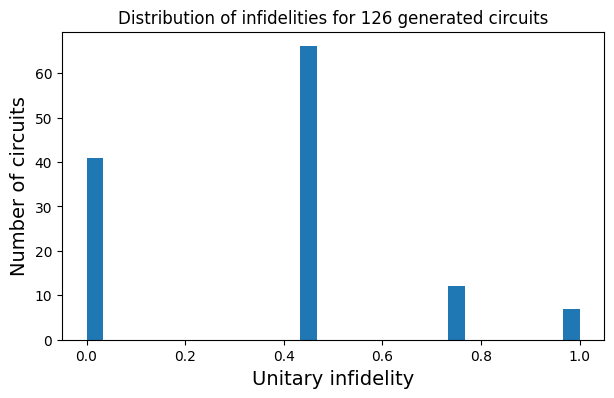

In [ ]:
plt.figure(figsize=(7, 4))
plt.title(
    f"Distribution of infidelities for {len(got_unitaries)} generated circuits",
    fontsize=12,
)
plt.ylabel("Number of circuits", fontsize=14)
plt.xlabel("Unitary infidelity", fontsize=14)
plt.hist(infidelities, bins=30)
plt.show()

As we can see, the model generated almost 30 circuits that compile the unitary with an infidelity close or equal to zero! The kernel with the lowest infidelity is:

In [ ]:
min_index = np.argmin(infidelities)

print(f"The best kernel has an infidelity of {infidelities[min_index]:0.2},")

input_state = [0] * (2**num_of_qubits)
input_state[0] = 1
print(cudaq.draw(kernel_list[min_index], input_state))

print(f"with the unitary:")
print(np.round(got_unitaries[min_index], 4))

The best kernel has an infidelity of 3.4e-09,
     ╭───╮╭───╮                  
q0 : ┤ x ├┤ z ├──●────────────●──
     ╰─┬─╯╰───╯  │          ╭─┴─╮
q1 : ──●─────────●────────╳─┤ x ├
       │  ╭───╮╭─┴─╮╭───╮ │ ╰─┬─╯
q2 : ──●──┤ h ├┤ x ├┤ z ├─╳───●──
          ╰───╯╰───╯╰───╯        

with the unitary:
[[ 0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j]
 [ 0.    +0.j -0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j -0.7071+0.j  0.    +0.j  0.    +0.j]
 [-0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j]
 [ 0.    +0.j  0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j -0.7071+0.j  0.    +0.j  0.    +0.j]
 [ 0.    +0.j  0.    +0.j  0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.7071+0.j]
 [ 0.    +0.j  0.    +0.j  0.    +0.j  0.7071+0.j  0.    +0.j  0.    +0.j  0.7071+0.j  0.    +0.j]
 [ 0.    +0.j  0.    +0.j -0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.7071+0.j]
 [ 0

which, as we can see, exactly compiled our targeted unitary:

In [ ]:
print(np.round(U, 4))

[[ 0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j]
 [ 0.    +0.j -0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j -0.7071+0.j  0.    +0.j  0.    +0.j]
 [-0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j]
 [ 0.    +0.j  0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j -0.7071+0.j  0.    +0.j  0.    +0.j]
 [ 0.    +0.j  0.    +0.j  0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.7071+0.j]
 [ 0.    +0.j  0.    +0.j  0.    +0.j  0.7071+0.j  0.    +0.j  0.    +0.j  0.7071+0.j  0.    +0.j]
 [ 0.    +0.j  0.    +0.j -0.7071+0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.    +0.j  0.7071+0.j]
 [ 0.    +0.j  0.    +0.j  0.    +0.j -0.7071+0.j  0.    +0.j  0.    +0.j  0.7071+0.j  0.    +0.j]]


## Select a circuit that meets specific criteria

As we have seen above, we now have almost 30 kernels that compile the desired unitary! This is particularly valuable when dealing with hardware constraints, where, for instance, we might want to avoid using certain qubits or specific gates. One practical example is finding the circuit with the fewest Toffoli gates (also known as `ccx`). In our `vocab` definition above, we identified that `ccx` corresponds to the label 5 in our tokenized tensors. Let's use this information to search for the circuit that minimizes the number of `ccx` gates:

In [ ]:
# First, we remove possible duplicates and only pick distinct circuits
_, idx_unique = np.unique(np.array(valid_tensors), axis=0, return_index=True)
unique_tensors = torch.stack(valid_tensors)[idx_unique]
unique_infidelities = infidelities[idx_unique]
unique_kernels = [kernel_list[idx] for idx in idx_unique]

# Then, find the correct circuits
idx_correct = torch.argwhere(torch.tensor(unique_infidelities) < 0.01).flatten()
correct_tensors = unique_tensors[idx_correct]
print(f"The model generated {correct_tensors.shape[0]} distinct correct circuits.")

# Now let's flatten the last two dimensions (related to the actual circuit) and find out how many 5's (i.e. ccx) gates each circuit has:
num_ccx = (correct_tensors.flatten(1, 2) == 5).sum(1)
print("These circuits have this number of ccx gates:", num_ccx)

The model generated 20 distinct correct circuits.
These circuits have this number of ccx gates: tensor([3, 3, 1, 1, 3, 3, 3, 1, 1, 1, 5, 3, 3, 3, 3, 3, 1, 1, 1, 1])


As we can see, it appears that the diffusion model (DM) requires at least one Toffoli gate to compile the unitary. We can now print a few of these circuits to select the one that best suits our needs, or to study whether there are any interesting patterns the model employs for this specific unitary.

In [ ]:
# Get the correct kernels
correct_kernels = [unique_kernels[idx] for idx in idx_correct]

# Get the ones with only one ccx
correct_kernels_ccx1 = [correct_kernels[idx] for idx in torch.argwhere(num_ccx == 1).flatten()]

# Draw a few of these circuits
for kernel in correct_kernels_ccx1[:2]:
    print(cudaq.draw(kernel, input_state))

     ╭───╮          ╭───╮     
q0 : ┤ x ├───────●──┤ z ├─────
     ╰─┬─╯╭───╮╭─┴─╮╰───╯     
q1 : ──●──┤ h ├┤ x ├──╳───────
       │  ├───┤├───┤  │  ╭───╮
q2 : ──●──┤ h ├┤ z ├──╳──┤ h ├
          ╰───╯╰───╯     ╰───╯

     ╭───╮          ╭───╮        
q0 : ┤ x ├───────●──┤ z ├────────
     ╰─┬─╯╭───╮╭─┴─╮╰───╯   ╭───╮
q1 : ──●──┤ h ├┤ x ├──────╳─┤ z ├
       │  ├───┤├───┤╭───╮ │ ├───┤
q2 : ──●──┤ z ├┤ z ├┤ h ├─╳─┤ h ├
          ╰───╯╰───╯╰───╯   ╰───╯



In [ ]:
# Get the ones with more than one ccx
correct_kernels_ccx3 = [correct_kernels[idx] for idx in torch.argwhere(num_ccx == 3).flatten()]

# Draw a few of these circuits
for kernel in correct_kernels_ccx3[:2]:
    print(cudaq.draw(kernel, input_state))

     ╭───╮          ╭───╮        
q0 : ┤ x ├───────●──┤ z ├─────●──
     ╰─┬─╯       │  ╰───╯   ╭─┴─╮
q1 : ──●─────────●────────╳─┤ x ├
       │  ╭───╮╭─┴─╮╭───╮ │ ╰─┬─╯
q2 : ──●──┤ h ├┤ x ├┤ z ├─╳───●──
          ╰───╯╰───╯╰───╯        

     ╭───╮          ╭───╮             
q0 : ┤ x ├───────●──┤ z ├──────────●──
     ╰─┬─╯       │  ├───┤        ╭─┴─╮
q1 : ──●─────────●──┤ z ├─╳──────┤ x ├
       │  ╭───╮╭─┴─╮├───┤ │ ╭───╮╰─┬─╯
q2 : ──●──┤ h ├┤ x ├┤ z ├─╳─┤ z ├──●──
          ╰───╯╰───╯╰───╯   ╰───╯     



<div class="alert alert-block alert-success">
    
## Exercise: Noise model

Define the `noise_model` as follows. Using this noise_model, verify that a lower number of ccx gates yields better results.

Tips:
1. To simulate a noisy circuit, using a density matrix simulator is convenient. e.g. `cudaq.set_target("density-matrix-cpu")`

2. The `cudaq.sample` function can take a noise model as an argument to perform a simulation with noise. e.g. `cudaq.sample(kernel, noise_model=noise_model)`.

See [Noisy Simulation example](https://nvidia.github.io/cuda-quantum/latest/examples/python/noisy_simulations.html) for more details.
</div>

In [ ]:
def tensor(matrices):
    return functools.reduce(np.kron, matrices)


def depolarizing_kraus(p: float, n: int = 2):
    I = np.array([[1, 0], [0, 1]], dtype=np.complex128)
    X = np.array([[0, 1], [1, 0]], dtype=np.complex128)
    Y = np.array([[0, -1j], [1j, 0]], dtype=np.complex128)
    Z = np.array([[1, 0], [0, -1]], dtype=np.complex128)

    paulis = [I, X, Y, Z]

    # Kraus operators
    kraus_operators = [np.sqrt(1 - p) * tensor([I] * n)]
    coeff = np.sqrt(p / (4**n - 1))

    for paulis in itertools.product(paulis, repeat=n):
        if not all(np.array_equal(p, I) for p in paulis):
            kraus_operators.append(coeff * tensor(paulis))

    return kraus_operators


noise_model = cudaq.NoiseModel()
noise_model.add_all_qubit_channel("ccx", cudaq.KrausChannel(depolarizing_kraus(0.1, n=3)))
noise_model.add_all_qubit_channel("cx", cudaq.KrausChannel(depolarizing_kraus(0.01)))

In [ ]:
# Example of execution
cudaq.set_target("density-matrix-cpu")
shots_count = 5000

# Sample with noiseless simulation
result = dict(cudaq.sample(correct_kernels[0], input_state, shots_count=shots_count).items())

In [ ]:
# Sample using noisy simulation for kernel with only 1 ccx gates
result_ccx = dict(
    cudaq.sample(
        correct_kernels_ccx1[0],
        input_state,
        noise_model=noise_model,
        shots_count=shots_count,
    ).items()
)

In [ ]:
# Sample using noisy simulation for kernel with 3 ccx gates
result_ccx3 = dict(
    cudaq.sample(
        correct_kernels_ccx3[0],
        input_state,
        noise_model=noise_model,
        shots_count=shots_count,
    ).items()
)

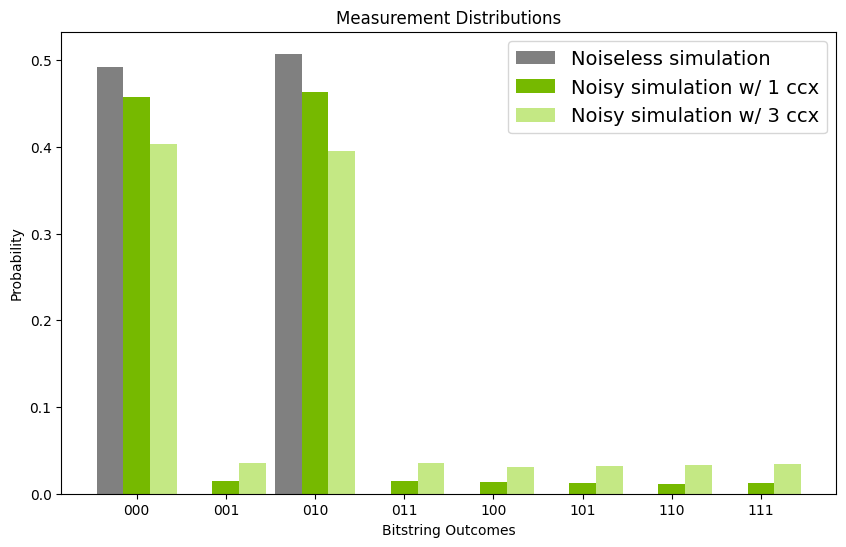

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Merge all bitstrings to ensure consistency across results
bitstrings = sorted(set(result_ccx.keys()) | set(result.keys()) | set(result_ccx3.keys()))


# Function to extract probabilities
def get_probabilities(result, keys):
    total_shots = sum(result.values())
    return [result.get(k, 0) / total_shots for k in keys]


# Extracting probabilities
prob = get_probabilities(result, bitstrings)
prob_ccx = get_probabilities(result_ccx, bitstrings)
prob_ccx3 = get_probabilities(result_ccx3, bitstrings)

# Bar width
bar_width = 0.3
x = np.arange(len(bitstrings))

# Plot bars
plt.figure(figsize=(10, 6))
plt.bar(x - bar_width, prob, bar_width, label="Noiseless simulation", color="#808080")
plt.bar(x, prob_ccx, bar_width, label="Noisy simulation w/ 1 ccx", color="#76B900")
plt.bar(
    x + bar_width,
    prob_ccx3,
    bar_width,
    label="Noisy simulation w/ 3 ccx",
    color="#c4e884",
)

# Labels
plt.xticks(x, bitstrings)
plt.xlabel("Bitstring Outcomes")
plt.ylabel("Probability")
plt.title("Measurement Distributions")
plt.legend(fontsize=14)

# Show plot
plt.show()